In [232]:
import warnings; warnings.simplefilter('ignore')

import torch
import torch.nn as nn
import numpy as np
import time
from cell.utils import *
from cell.graph_utils import *
from cell import analysis
from cell import math_utils
from torch.nn import functional as F
from IPython.display import Image
from collections import Counter
from stellargraph import StellarDiGraph
from stellargraph.data import BiasedRandomWalk
import cell.BiasedDirectedWeightedWalk as BDWW
from cell.Word2vec import prepare_vocab, dataloader, wv
import cell.Word2vec.Emitter_Receiver_with_Negative_sampling  as ERN

os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [161]:
import imp
from cell import  graph_utils


imp.reload(graph_utils)


<module 'cell.graph_utils' from '/Users/fahimehb/Documents/git-workspace/celltypes/cell/graph_utils.py'>

#### Negative sampling in word2vec:

More frequent words are more likely to be selected as negative samples. These more frequent words are the words such as ("the", "of", "for" ...). The equation that is used is:

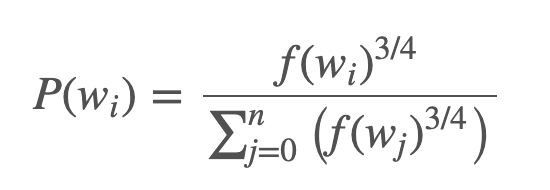

In [4]:
Image("/Users/fahimehb/Documents/NPP_GNN_project/figures/eq.png", width=400, height=50)

f(w_i) is the frequency of that word in the entire corpus and p(w_i) is the probability that a given word is picked as a negative sample. As it is clear, negative sample is not picked per word, but it is based on the whole corpus.  

### Negative sampling for directed weighted relatively small graph

We think negative sampling for a small graph should be chosen for each node separately. For the directed graph that we are interested in generating two embeddings (emitters and receivers), each node will have different negative samples if its role is emitter or receiver. For example for the following toy model lets look at node 1. Node 1 is receiving signal from node 5, therefore in the embedding space, we would like to have the emitter node 5 representation close to the receiver node 1 representation:

Posivite example: (E_5, R_1)

This is actually a positive example for our model, now in order to generate the negative example, receiver node 1, has a very low chance to receive signal from emitter node 3 or 2 or 7. Therefore any of these examples are a good negative example for the positive example above:

Negative examples: (E_3, R_1), (E_2, R_1), (E_7, R_1)

So far we have positive and negative examples for R_1. Now lets look at the positive and negative example for emitter node 1 (E_1). Emitter node 1 send signal to 2 with a very high probability based on its weight. So This is one possible example:

Positive example: (E_1, R_2)

Now for the negative examples, there is a low chance that node 1 send signal to receiver node 8 or 11. So the negative examples can be:

Negative examples:  (E_1, R_8), (E_1, R_11)

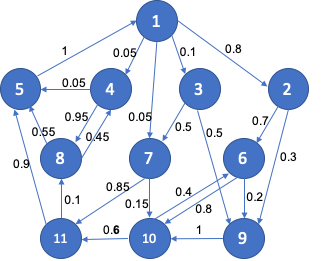

In [5]:
Image("/Users/fahimehb/Documents/NPP_GNN_project/code/directed_weighted_footbal_4_3_3_v2.png", width=400, height=50)

# Katz proximity:

In [249]:
edges = pd.DataFrame([['1', '2', 0.8],
                      ['1', '3', 0.1],
                      ['1', '4', 0.05],
                      ['1', '7', 0.05],
                      ['2', '6', 0.7],
                      ['2', '9', 0.3],
                      ['3', '9', 0.5],
                      ['3', '7', 0.5],
                      ['4', '8', 0.95],
                      ['4', '5', 0.05],
                      ['5', '1', 1],
                      ['6', '9', 0.2],
                      ['6', '10', 0.8],
                      ['7', '10', 0.15],
                      ['7', '11', 0.85],
                      ['8', '5', 0.55],
                      ['8', '4', 0.45],
                      ['9', '10', 1],
                      ['10', '11', 0.6],
                      ['10', '6', 0.4],
                      ['11', '8', 0.1],
                      ['11', '5', 0.9]], columns=['source', 'target', 'weight'])

reversed_edges = pd.DataFrame([['2', '1', 0.8],
                      ['3', '1', 0.1],
                      ['4', '1', 0.05],
                      ['7', '1', 0.05],
                      ['6', '2', 0.7],
                      ['9', '2', 0.3],
                      ['9', '3', 0.5],
                      ['7', '3', 0.5],
                      ['8', '4', 0.95],
                      ['5', '4', 0.05],
                      ['1', '5', 1],
                      ['9', '6', 0.2],
                      ['10', '6', 0.8],
                      ['10', '7', 0.15],
                      ['11', '7', 0.85],
                      ['5', '8', 0.55],
                      ['4', '8', 0.45],
                      ['10', '9', 1],
                      ['11', '10', 0.6],
                      ['6', '10', 0.4],
                      ['8', '11', 0.1],
                      ['5', '11', 0.9]], columns=['source', 'target', 'weight'])

edges= reversed_edges

weight_mat = graph_utils.return_weight_mat_from_edgelist(edges, directed=True)
weight_mat = weight_mat.loc[[str(i) for i in range(1,12)]][[str(i) for i in range(1,12)]]

In [310]:
Katz = pd.DataFrame(analysis.Katz_proximity(weight_mat, 0.439), index=[str(i) for i in range(1,12)], columns=[str(i) for i in range(1,12)])

In [312]:
sum(Katz.loc['2'])

0.7020898282803169

In [251]:
backward = {}

for node in [str(i) for i in range(1,12)]:
    backward[node] = analysis.get_distance_node_importance(node, Katz)

In [257]:
nxg = build_nx_graph(source_target_weight=edges, directed=True)

In [269]:
L = nx.directed_laplacian_matrix(nxg)
e = numpy.linalg.eigvals(L.A)
print("Largest eigenvalue:", max(e))

Largest eigenvalue: 1.9318315375958892


In [277]:
nx.katz_centrality(nxg, 0.01)

{'2': 0.3014837992681657,
 '1': 0.3075436288014704,
 '3': 0.3014840977069731,
 '4': 0.3014844050102996,
 '7': 0.3015139474973957,
 '6': 0.30148409475213345,
 '9': 0.29849910389051865,
 '8': 0.3014844050102996,
 '5': 0.2985594033038183,
 '10': 0.30151365201342795,
 '11': 0.3014844050102996}

In [279]:
nx.pagerank(nxg,0.4) 

{'2': 0.08167073400148127,
 '1': 0.13239330532818247,
 '3': 0.09661023332150653,
 '4': 0.09362309514711543,
 '7': 0.07675008006994707,
 '6': 0.07319598999111782,
 '9': 0.07078059874776592,
 '8': 0.1040166076379559,
 '5': 0.10750309434488162,
 '10': 0.07914694934855557,
 '11': 0.0843093120614904}

In [255]:
Katz.loc['1']

1     0.000010
2     0.000005
3     0.000042
4     0.001027
5     0.100001
6     0.000045
7     0.000778
8     0.005546
9     0.000055
10    0.000545
11    0.009056
Name: 1, dtype: float64

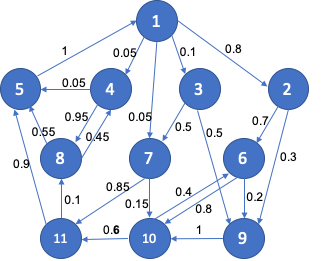

In [239]:
Image("/Users/fahimehb/Documents/NPP_GNN_project/code/directed_weighted_footbal_4_3_3_v2.png", width=400, height=50)

## Generating negative samples:

In order to do the training, we always walk on the graph before staring to build machine learning model. The walk is done based on the weights and the direction of the edges. Here is a short portion of a walk for the graph above: 

In [ ]:
walk_path = "/Users/fahimehb/Documents/NPP_GNN_project/dat/10000_footbal_weighted-directed_walk.csv"
walks = read_list_of_lists_from_csv(walk_path)

In [ ]:
walks[0][0:15]

All the positive examples are going to be taken from the walk intself. For example in the walk above, these are the positive examples that can be fed to the model later: 

Positive examples: (R_3, E_1), (E_3, R_7), (R_7, E_3), (E_7, R_11)

In order to find the negative examples for each node of a graph. We do the following: 

### 1- To find the negative example for emitters:

 - First we walk on the graph based on the weights and the direction of the edges, from each node, we walk multiple time and the length of each walk is for example 100 time. Lets say we start from node "X", we walk 100 times and the length of that walk is 100 steps. Then we compute the frequency of visiting all other nodes of the graph during these walks. Based on these frequencies we can compute the probability of visiting each node starting from node X, we call this f(n_i). Since we would like to find "Negative examples", it means that we want to find the less frequent nodes that were visited starting from node X. The less frequent node is a good negative example and we would like to make it far from Emitter node X. right? okay now, we have the probabilties, if we compute the 1-probabilities and then apply a softmax, then we will have higher probabilities for less frequent words. So we will use these probabilities to sample a node as negative sample for node X. In the following equations, f(n_i) is the frequency of node n_i, p(n_i) is the probability of node n_i and N(n_i) is the probability of choosing node (n_i) as a negative sample for emitter node X. T is the softmax temperature

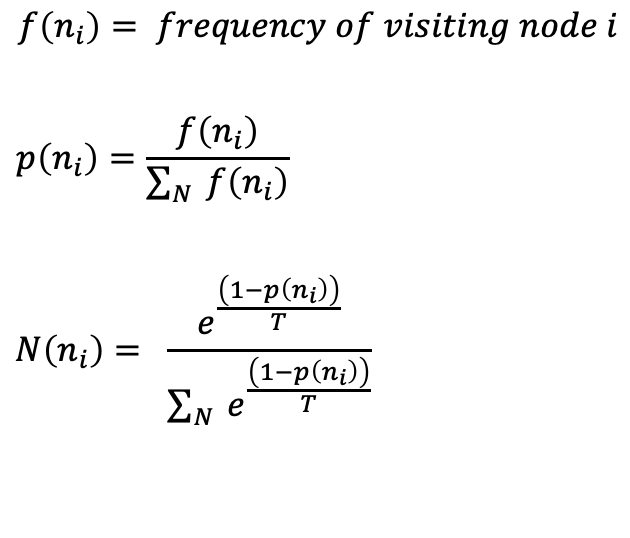

In [10]:
Image("/Users/fahimehb/Documents/NPP_GNN_project/figures/eq2.png", width=400, height=50)

### 2 - To find the negative example for receivers:

- For the receiver negative examples, we can not use the walks that was used above. What we suggest is that we reverse the edges, and we walk on the reveresed graph. and perform the exact same analysis above in order to find negative emitter examples for receiver node X. The only problem is that when we reverse the graph, we need to normalize to 1 the outgoing edges from each node. In another word the probability of going from one node to every other node depeneds on its outgoing edge weights and those probabilities for each node should sum to 1. The rest of the procedure is as above.




## We performed 100 walks from each node with a length of 10 for the real graph and for the reversed graph

#### Lets see how the negative examples look like

In [227]:
walk_path = "/Users/fahimehb/Documents/NPP_GNN_project/dat/10_footbal_weighted-directed_walk.csv"
reversed_walk_path = "/Users/fahimehb/Documents/NPP_GNN_project/dat/10_inverted_footbal_weighted-directed_walk.csv"

walks = read_list_of_lists_from_csv(walk_path)
reversed_walks = read_list_of_lists_from_csv(reversed_walk_path)

real walk:

In [228]:
walks[0][0:10]

['1', '2', '6', '9', '10', '11', '5', '1', '2', '9']

In [229]:
walks[1][0:10]

['1', '2', '9', '10', '6', '10', '6', '10', '11', '5']

reversed walk:

In [85]:
reversed_walks[0][0:10]

['2', '1', '5', '11', '10', '6', '2', '1', '5', '11']

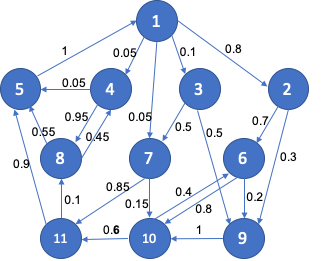

In [86]:
Image("/Users/fahimehb/Documents/NPP_GNN_project/code/directed_weighted_footbal_4_3_3_v2.png", width=400, height=50)

In [87]:
freq_table = graph_utils.get_frequency_tables(walks=walks, node_list=[str(i) for i in range(1, 12)])
reversed_freq_table = graph_utils.get_frequency_tables(walks=reversed_walks, node_list=[str(i) for i in range(1, 12)])

In [88]:
prob_table = {}
reversed_prob_table = {}

for k in freq_table:
    prob_table[k] = graph_utils.get_probability_from_freq_tables(freq_table[k])

for k in reversed_freq_table:
    reversed_prob_table[k] = graph_utils.get_probability_from_freq_tables(reversed_freq_table[k])
    
negative_sample_prob = {}
reversed_negative_sample_prob = {}

for k in prob_table:
    negative_sample_prob[k] = graph_utils.get_negative_probability_from_probability(prob_table[k], softmax_T=0.05)

for k in reversed_prob_table:
    reversed_negative_sample_prob[k] = graph_utils.get_negative_probability_from_probability(reversed_prob_table[k], softmax_T=0.05)

In [225]:
freq_table['1']

Counter({'2': 140,
         '6': 155,
         '9': 77,
         '10': 183,
         '11': 115,
         '5': 105,
         '1': 95,
         '8': 55,
         '4': 41,
         '3': 15,
         '7': 19})

Lets look at the Emitter node 1, the probability of visiting any other node, starting from node 1 during the walks is as the following:

In [226]:
prob_table['1']

{'2': 0.14,
 '6': 0.155,
 '9': 0.077,
 '10': 0.183,
 '11': 0.115,
 '5': 0.105,
 '1': 0.095,
 '8': 0.055,
 '4': 0.041,
 '3': 0.015,
 '7': 0.019}

Now we would like to find some negative samples from emitter node 1. So from the probability table above, by applying the equations that we explained earlier, we will form another table in which the nodes that were visited less, have a higher probability. This means if we use this table to suggesting negative samples ... there is a high chance to suggest receiver node 3 and receiver node 7 as negative samples becasue they have a higher probability in the negative table:

In [90]:
negative_sample_prob['1']

{'2': 0.020852220870044725,
 '6': 0.015447705162208704,
 '9': 0.07351286751454465,
 '10': 0.008823869204317719,
 '11': 0.03437950008977987,
 '5': 0.04199121623382491,
 '1': 0.05128818732649381,
 '8': 0.11414396004330071,
 '4': 0.15102727643154454,
 '3': 0.25403205481657476,
 '7': 0.23450114230736566}

Now for receiver node 1, the reversed walks gave us the following table:

In [91]:
reversed_prob_table['1']

{'5': 0.19,
 '8': 0.174,
 '4': 0.132,
 '1': 0.108,
 '11': 0.123,
 '7': 0.078,
 '3': 0.073,
 '10': 0.051,
 '6': 0.029,
 '2': 0.02,
 '9': 0.022}

which means nodes 5, 8, 4 were visited a lot during the reversed walk. This means emitters 5, 8, 4 send signals that are received by node 1 ... is that clear? so now, from the same table node 9, 6, 2 have very low probability ... so these are good negative examples. So we would like to make a negative probability table that node 9, 6, and 2 have high probability:


In [92]:
reversed_negative_sample_prob['1']

{'5': 0.007450661312997631,
 '8': 0.010260512556792839,
 '4': 0.02376711245140265,
 '1': 0.03840942204675183,
 '11': 0.028454399698087815,
 '7': 0.06998653002352032,
 '3': 0.07734707763902265,
 '10': 0.12009736578086695,
 '6': 0.18647604677214866,
 '2': 0.22325236100193113,
 '9': 0.21449851071647755}

So this table is going to be used to draw negative samples for receiver node 1. 

### These plots show negative emitter and receiver probabilities for each node:

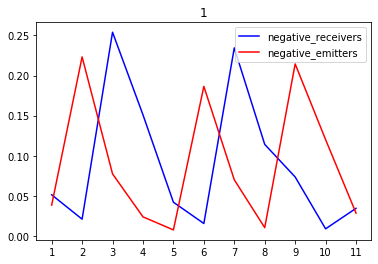

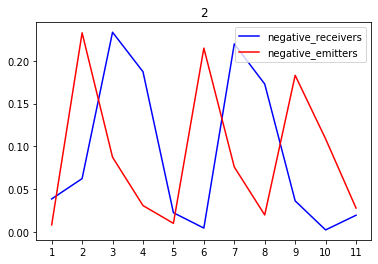

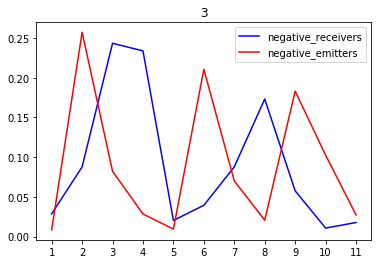

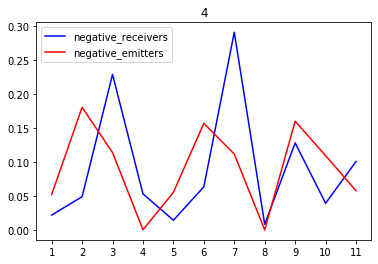

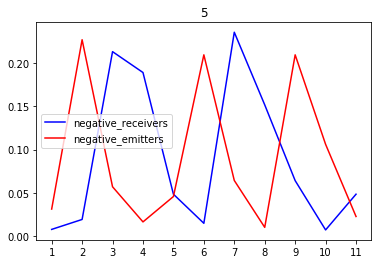

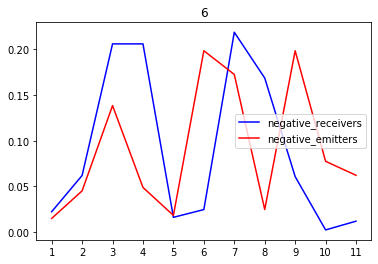

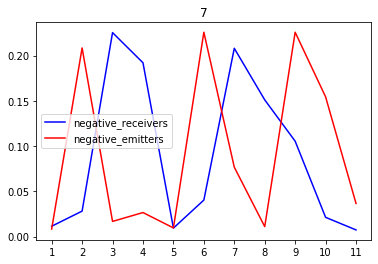

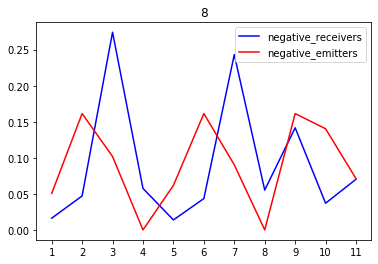

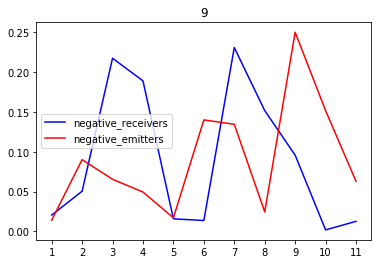

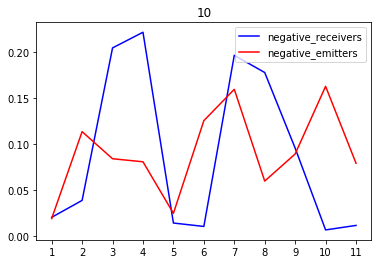

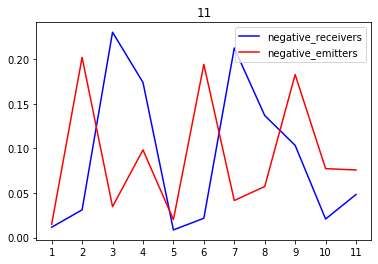

In [95]:
for node in range(1, 12):
    node = str(node)

    ord_nodes = [str(i) for i in range(1, 12)]

    plt.plot(ord_nodes, [negative_sample_prob[node][k] for k in ord_nodes], label='negative_receivers', c='Blue')
    plt.plot(ord_nodes, [reversed_negative_sample_prob[node][k] for k in ord_nodes], label='negative_emitters', c='Red')
    plt.legend()
    plt.title(node)
    plt.show()

The following codes can be used to check how negative samples are drawn:
``` python
word = '1'
tmp = Counter([math_utils.weighted_choice([i for i in negative_sample_prob[word].keys()],
                                           [i for i in negative_sample_prob[word].values()]) for it in range(10000)])
total = sum(tmp.values(), 0.0)
for key in tmp:
    tmp[key] /= total
print(tmp)
print(negative_sample_prob['1'])
#The two printed list should be comparable
```

# Emitter Receiver Model

One thing that we need to be careful about is the length of the walk for the model and for the negative samples. For the negative sample probability table preparation, if the length of the walk is long, then the negative emitters and receivers for all the nodes will become similar becasue in long walks, we always be exploring the well connected regions of the graph. and therefore the frequencies and the subsequenct probabilities will be similar. So for preparting the negative sample probability tables we performed short walks of length 10 on the graph. However for the model training the length of the walks can be long, I think!

In [98]:
walk_path = "/Users/fahimehb/Documents/NPP_GNN_project/dat/10000_footbal_weighted-directed_walk.csv"

walks = read_list_of_lists_from_csv(walk_path)

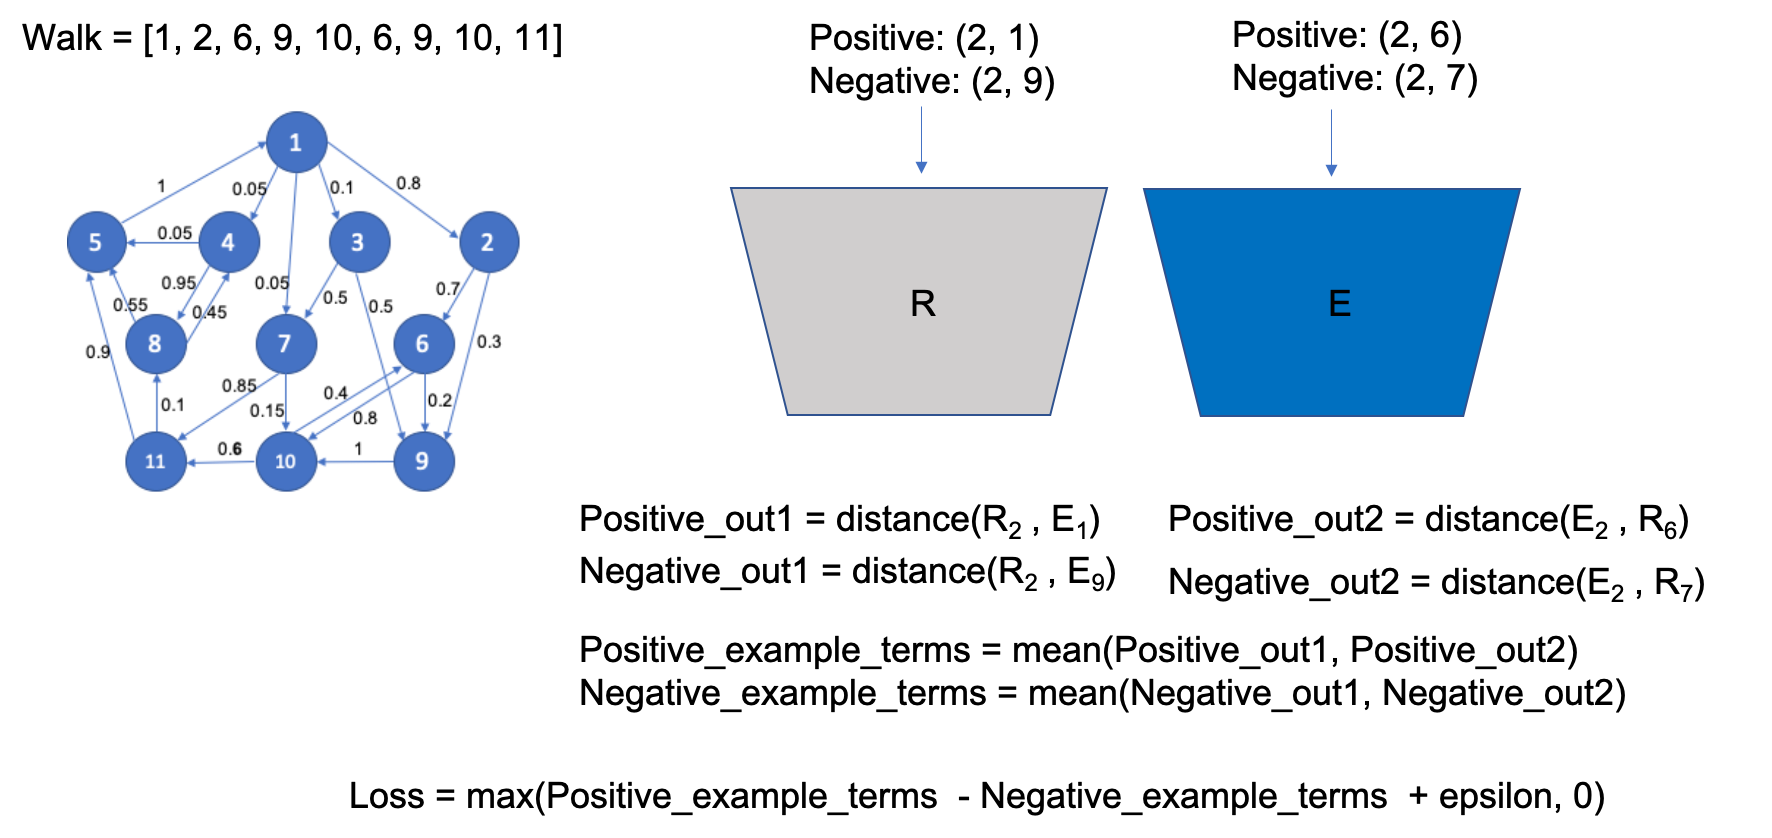

In [93]:
Image("/Users/fahimehb/Documents/NPP_GNN_project/figures/E_R_mdel.png", width=1000, height=100)

In [162]:
window = 1
n_neg = 1

emitter_tuple_list, receiver_tuple_list = ERN.emitter_receiver_negative_tuples(corpus=walks, 
                                                                               window=window, 
                                                                               n_neg=n_neg,
                                                                               negative_prob_table=negative_sample_prob,
                                                                               reversed_negative_prob_table=reversed_negative_sample_prob
                                                                              )

In [163]:
walks[0][0:10]

['1', '3', '7', '11', '5', '1', '2', '6', '10', '6']

In [164]:
emitter_tuple_list[0:10]

[('3', '7', '9'),
 ('7', '11', '10'),
 ('11', '5', '3'),
 ('5', '1', '7'),
 ('1', '2', '6'),
 ('2', '6', '3'),
 ('6', '10', '5'),
 ('10', '6', '4'),
 ('6', '10', '3'),
 ('10', '11', '3')]

In [165]:
receiver_tuple_list[0:10]

[('3', '1', '2'),
 ('7', '3', '6'),
 ('11', '7', '6'),
 ('5', '11', '8'),
 ('1', '5', '7'),
 ('2', '1', '2'),
 ('6', '2', '7'),
 ('10', '6', '2'),
 ('6', '10', '3'),
 ('10', '6', '6')]

In [172]:
node = '7'
all_emitter_examples = [(k) for (i,j,k) in emitter_tuple_list if i==node]
all_receiver_examples = [(k) for (i,j,k) in receiver_tuple_list if i==node]

In [175]:
Counter(all_emitter_examples).most_common()
# Counter(all_receiver_examples).most_common()

[('7', 330),
 ('3', 320),
 ('4', 300),
 ('8', 236),
 ('9', 142),
 ('6', 55),
 ('2', 53),
 ('10', 32),
 ('5', 13),
 ('1', 13),
 ('11', 7)]

In [176]:
negative_sample_prob[node]
# reversed_negative_sample_prob[node]

{'11': 0.007373055636276978,
 '5': 0.009372990712889537,
 '1': 0.011448196708932929,
 '2': 0.028158020242428243,
 '9': 0.10540733491684966,
 '10': 0.02128137389080845,
 '7': 0.20806119120612715,
 '6': 0.04035971866925787,
 '8': 0.15108343364673427,
 '3': 0.22538999771864393,
 '4': 0.19206468665105098}

In [179]:
vocabulary = prepare_vocab.get_vocabulary(corpus=walks)
word_2_index = prepare_vocab.get_word2idx(vocabulary, padding=False)
index_2_word = prepare_vocab.get_idx2word(vocabulary, padding=False)

n_nodes = len(vocabulary)
datasets = {}

datasets['E'] = []
emitter_dataset = dataloader.EmitterReceiverNegativeDataset_debug(tuples_list=emitter_tuple_list,
                                                                  wd_2_idx=word_2_index,
                                                                  n_pos=window, 
                                                                  n_neg=n_neg)
datasets['E'].append(emitter_dataset)
datasets['E'].append(n_nodes)


datasets['R'] = []
receiver_dataset = dataloader.EmitterReceiverNegativeDataset_debug(tuples_list=receiver_tuple_list,
                                                                  wd_2_idx=word_2_index,
                                                                  n_pos=window, 
                                                                  n_neg=n_neg)
datasets['R'].append(receiver_dataset)
datasets['R'].append(n_nodes)

keys, data_loader = ERN.build_data_loader(datasets, batch_size=2000, shuffle=False)

In [180]:
for batch_idx, all_data in enumerate(data_loader):
    break

In [216]:
q = all_data[0][0]
p = all_data[0][1]
n = all_data[0][2]

print([index_2_word[i.numpy().tolist()] for i in q][1000:1010])
print([index_2_word[i.numpy()[0]] for i in p][1000:1010])
print([index_2_word[i.numpy()[0]] for i in n][1000:1010])

['11', '5', '1', '2', '9', '10', '6', '10', '6', '9']
['5', '1', '2', '9', '10', '6', '10', '6', '9', '10']
['9', '4', '8', '4', '7', '7', '7', '8', '8', '9']


In [217]:
emitter_tuple_list[1000:1010]

[('11', '5', '9'),
 ('5', '1', '4'),
 ('1', '2', '8'),
 ('2', '9', '4'),
 ('9', '10', '7'),
 ('10', '6', '7'),
 ('6', '10', '7'),
 ('10', '6', '8'),
 ('6', '9', '8'),
 ('9', '10', '9')]

In [218]:
q = all_data[1][0]
p = all_data[1][1]
n = all_data[1][2]

print([index_2_word[i.numpy().tolist()] for i in q][1000:1010])
print([index_2_word[i.numpy()[0]] for i in p][1000:1010])
print([index_2_word[i.numpy()[0]] for i in n][1000:1010])

['11', '5', '1', '2', '9', '10', '6', '10', '6', '9']
['10', '11', '5', '1', '2', '9', '10', '6', '10', '6']
['4', '6', '6', '6', '2', '8', '4', '6', '7', '9']


In [219]:
receiver_tuple_list[1000:1010]

[('11', '10', '4'),
 ('5', '11', '6'),
 ('1', '5', '6'),
 ('2', '1', '6'),
 ('9', '2', '2'),
 ('10', '9', '8'),
 ('6', '10', '4'),
 ('10', '6', '6'),
 ('6', '10', '7'),
 ('9', '6', '9')]

In [220]:
class EmitterReceiverNegativeCoupled(nn.Module):
    """
    """
    def __init__(self, n_nodes=[93], embedding_size=2, n_arms=1):
        """
        """
        super(EmitterReceiverNegativeCoupled, self).__init__()
        self.n_nodes = n_nodes
        self.embedding_size = embedding_size
        self.n_arms = n_arms

        self.embeddings = nn.ModuleList([nn.Embedding(n_nodes[i], embedding_size) for i in range(n_arms)])
        self.linear = nn.ModuleList([nn.Linear(embedding_size,  n_nodes[i], bias=False) for i in range(n_arms)])
        self.softmax = nn.Softmax()

    def encoder(self, query_node, pos_nodes, neg_nodes, arm):
        q = self.embeddings[arm](query_node)
        p = self.embeddings[arm](pos_nodes).squeeze(1)
        if neg_nodes.shape[2] > 0:
            n = self.embeddings[arm](neg_nodes).squeeze(1)
        else :
            n = neg_nodes
        return q, p, n

    def forward(self, query_node, pos_nodes, neg_nodes):
        q_embedding = [None] * self.n_arms
        p_embeddings = [None] * self.n_arms
        n_embeddings = [None] * self.n_arms

        for arm in range(self.n_arms):
            q, p, n = self.encoder(query_node[arm], pos_nodes[arm], neg_nodes[arm], arm)
            q_embedding[arm] = q
            p_embeddings[arm] = p
            n_embeddings[arm] = n
        return q_embedding, p_embeddings, n_embeddings
    
    
def loss_emitter_receiver_negative_independent(q_embedding, p_embedding, n_embedding, n_arms):
    mean_pos_dist_squared = 0
    mean_neg_dist_squared = 0

    for arm in range(n_arms):
        other_arm = arm * -1 + 1
        pos_dist = q_embedding[arm] - p_embedding[other_arm]
        pos_dist_squared = (torch.norm(pos_dist, dim=2))**2
        mean_pos_dist_squared = mean_pos_dist_squared + torch.mean(pos_dist_squared)
        
        neg_dist = q_embedding[arm] - n_embedding[other_arm]
        neg_dist_squared = (torch.norm(neg_dist, dim=2))**2
        mean_neg_dist_squared = mean_neg_dist_squared +torch.mean(neg_dist_squared)

    mean_pos_dist_squared = mean_pos_dist_squared / n_arms
    mean_neg_dist_squared = mean_neg_dist_squared / n_arms
    
    loss = F.relu(mean_pos_dist_squared - mean_neg_dist_squared + 1)
    
    return mean_pos_dist_squared, mean_neg_dist_squared, loss

In [224]:
batch_size=2000
n_pos = 1
n_neg = 1
learning_rate = 0.00001
embedding_size = 2
n_arms = 2
n_epochs = 500

model = EmitterReceiverNegativeCoupled(embedding_size=embedding_size,
                                     n_nodes=[v[1] for (k, v) in datasets.items()],
                                     n_arms=n_arms).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

training_loss = []
for epoch in range(n_epochs):
    losses = []
    t0 = time.time()
    for batch_idx, all_data in enumerate(data_loader):
        query_node = [data[0].to(device) for data in all_data]
        pos_nodes = [data[1].to(device) for data in all_data]
        neg_nodes = [data[2].to(device) for data in all_data]

        query_node = [torch.reshape(query_node[i], (batch_size, 1)) for i in range(len(query_node))]
        pos_nodes = [torch.reshape(pos_nodes[i], (batch_size, 1, n_pos)) for i in range(len(pos_nodes))]
        neg_nodes = [torch.reshape(neg_nodes[i], (batch_size, 1, n_neg)) for i in range(len(neg_nodes))]
        
        optimizer.zero_grad()
        q_embedding, p_embedding, n_embedding = model(query_node, pos_nodes, neg_nodes)
        pos_dist, neg_dist, loss = loss_emitter_receiver_negative_independent(q_embedding, 
                                                                              p_embedding,
                                                                              n_embedding,
                                                                              n_arms)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    training_loss.append(np.mean(losses))
    print(f'epoch: {epoch + 1}/{n_epochs}, loss:{np.mean(losses):.4f}')
    print(f'pos_dist: {pos_dist:.4f}, neg_dist:{neg_dist:.4f}')


epoch: 1/500, loss:2.1423
pos_dist: 6.6363, neg_dist:5.4287
epoch: 2/500, loss:2.1381
pos_dist: 6.6321, neg_dist:5.4287
epoch: 3/500, loss:2.1339
pos_dist: 6.6279, neg_dist:5.4287
epoch: 4/500, loss:2.1296
pos_dist: 6.6237, neg_dist:5.4287
epoch: 5/500, loss:2.1254
pos_dist: 6.6195, neg_dist:5.4287
epoch: 6/500, loss:2.1211
pos_dist: 6.6153, neg_dist:5.4288
epoch: 7/500, loss:2.1169
pos_dist: 6.6112, neg_dist:5.4288
epoch: 8/500, loss:2.1127
pos_dist: 6.6070, neg_dist:5.4288
epoch: 9/500, loss:2.1084
pos_dist: 6.6029, neg_dist:5.4289
epoch: 10/500, loss:2.1042
pos_dist: 6.5988, neg_dist:5.4289
epoch: 11/500, loss:2.0999
pos_dist: 6.5946, neg_dist:5.4290
epoch: 12/500, loss:2.0957
pos_dist: 6.5905, neg_dist:5.4291
epoch: 13/500, loss:2.0915
pos_dist: 6.5864, neg_dist:5.4291
epoch: 14/500, loss:2.0873
pos_dist: 6.5823, neg_dist:5.4292
epoch: 15/500, loss:2.0830
pos_dist: 6.5783, neg_dist:5.4293
epoch: 16/500, loss:2.0788
pos_dist: 6.5742, neg_dist:5.4294
epoch: 17/500, loss:2.0746
pos_di

KeyboardInterrupt: 

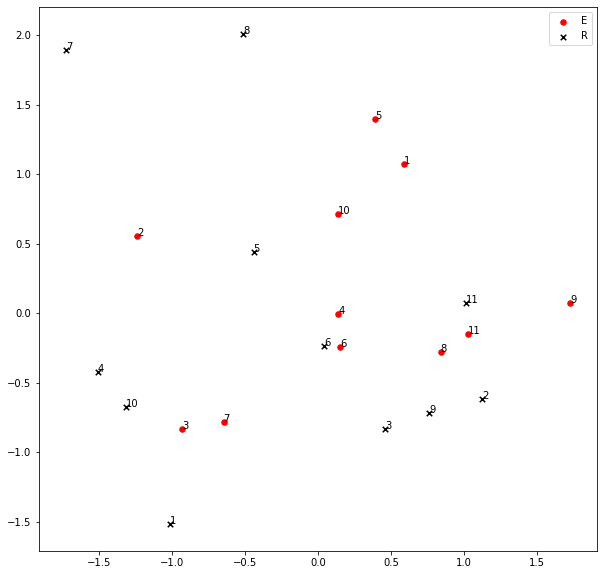

In [222]:
E = model.embeddings[0].weight.detach().numpy()
E = pd.DataFrame(E, columns=["Z"+str(i) for i in range(embedding_size)], index=index_2_word.values())
E.index = E.index.astype('str')

R = model.embeddings[1].weight.detach().numpy()
R = pd.DataFrame(R, columns=["Z"+str(i) for i in range(embedding_size)], index=index_2_word.values())
R.index = R.index.astype('str')

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()

ax.scatter(E['Z0'], E['Z1'], c = 'Red', s=30, marker='o', label="E")
for j, txt in enumerate(E.index.tolist()):
    ax.text(E['Z0'][j], E["Z1"][j], txt, size=10)

ax.scatter(R['Z0'], R['Z1'], c = "black", s=30, marker='x', label="R")
for j, txt in enumerate(R.index.tolist()):
    ax.text(R['Z0'][j], R["Z1"][j], txt, size=10)

ax.legend()
plt.show()

Resutls are not good!

In [2]:
[[1, 2]] + [[3, 2]]

[[1, 2], [3, 2]]